# Project 5. Credit Scoring
## Задача: 
- Написать скоринговую модель предсказания дефолта клиентов банка.
### Описание датасета:
- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')


from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

RANDOM_SEED = 42

# Loading the data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv('score_sample_submission.csv')

In [3]:
print("Размер тренировочного датасета:", train.shape)
print("Размер тестового датасета:", test.shape)

Размер тренировочного датасета: (73799, 19)
Размер тестового датасета: (36349, 18)


In [4]:
# объединяем два датасета в один, пометив трейн и тест
train['test'] = 0
test['test'] = 1

data = pd.concat([train, test], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

# Preprocessing the data

Посмотрим на пропуски и уникальные значения в датасете.

In [5]:
display(data.isna().sum())
print( )
display(data.nunique().sort_values(ascending=False))

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
test                    0
dtype: int64

client_id           110148
score_bki           102618
income                1207
app_date               120
age                     52
bki_request_cnt         40
decline_app_cnt         24
region_rating            7
education                5
sna                      4
first_time               4
work_address             3
home_address             3
foreign_passport         2
sex                      2
good_work                2
car                      2
car_type                 2
default                  2
test                     2
dtype: int64

В client_id нету дупликатов, что не вызывает подозрений.

А вот в числовом признаке decline_app_cnt крайне мало значении.

Пропусков почти не наблюдается. Только в одном столбце education. Так как пропусков крайне мало, их стоит заменить.

<BarContainer object of 5 artists>

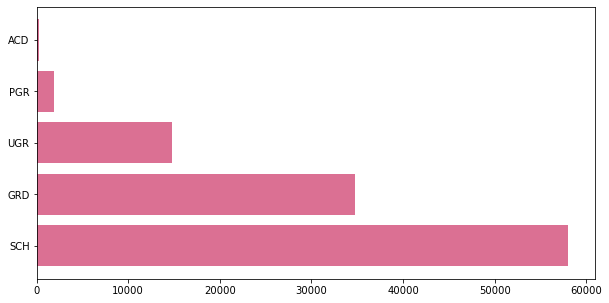

In [6]:
plt.figure(figsize=(10,5))
plt.barh(data.education.value_counts().index.values, data.education.value_counts(),color='palevioletred')

In [7]:
# Заменим пустые строки самым частым значением
data['education'].fillna('SCH', inplace=True)

In [8]:
# Разделим столбцы по типу
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] 
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time'] 
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt',  'region_rating', 'income'] 

А вот признак app_date не попал в эти категории, так что давайте посмотрим на этот признак и сделаем новые на основе него.

In [9]:
data['app_date'] = pd.to_datetime(data.app_date)
data['weekend'] = data.app_date.apply(lambda x: 0 if x.weekday()<4 else 1)
data['month'] = data.app_date.apply(lambda x: x.month)

In [10]:
min_d = data['app_date'].min()
data['antiquity'] = data.app_date.apply(lambda x: (x-min_d).days)

In [11]:
cat_cols.append('month')
bin_cols.append('weekend')
num_cols.append('antiquity')

Теперь посмотрим на наш целевой признак

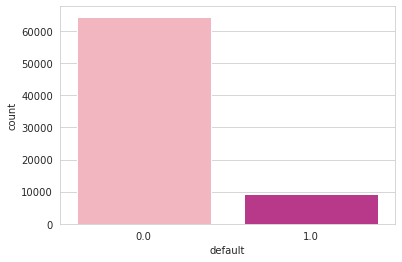

In [14]:
sns.set_style("whitegrid")
sns.countplot(x = data['default'], palette="RdPu")

Распределение целевой переменной крайне несбалансировано, что может повлиять на выбор метрик оценки модели. 
Так же можно рассмотреть Oversampling для того, чтобы сделать датасет более сбалансированным.

## Рассмотрим числовые признаки

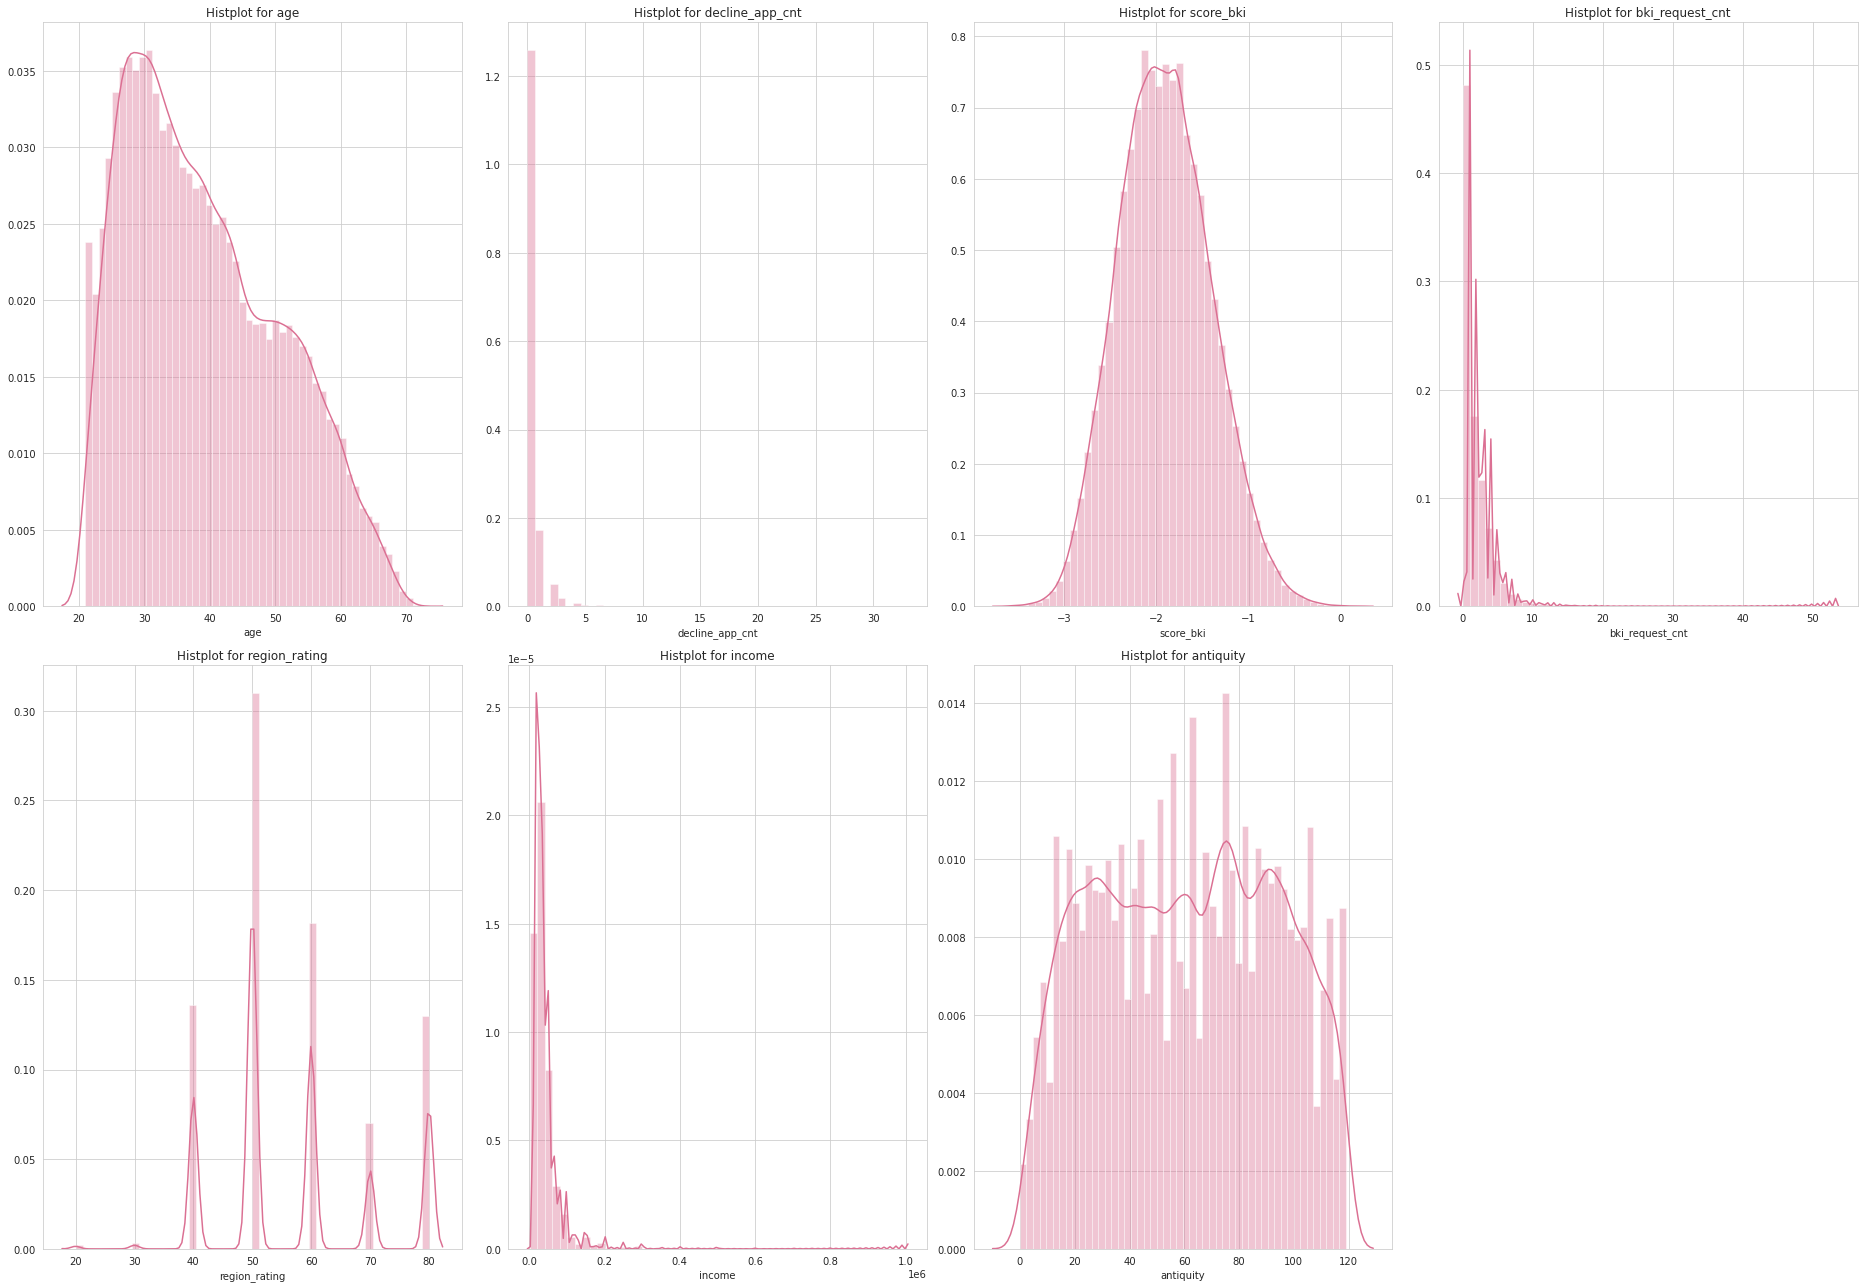

In [16]:
plt.figure(figsize=[26, 18])


for i,col in enumerate(num_cols):
    plt.subplot(2, 4, i+1)
    sns.distplot(data[col],color='palevioletred').set(title = 'Histplot for ' + col)

plt.tight_layout()
plt.show()

- Распределения признаков bki_request_cnt, decline_app_cnt, income являются сильно смещенными вправо
- Так же можно отметить признак age также имеет тяжелый правый хвост 
- Распределения score_bki, region_rating, age являются более нормальными
- Все же стоит взглянуть на признак declined_app_cnt, в котором только 24 уникальных значений, более приближенно
- А вот region rating выглядит скорее как категориальный
- Вот распределение antiquity вообще не нормально

In [17]:
data.decline_app_cnt.value_counts(normalize=True)

0     0.830437
1     0.113484
2     0.032883
3     0.012392
4     0.005502
5     0.002315
6     0.001416
7     0.000527
8     0.000336
9     0.000263
10    0.000145
11    0.000091
12    0.000045
13    0.000036
14    0.000027
16    0.000027
30    0.000009
15    0.000009
19    0.000009
20    0.000009
21    0.000009
22    0.000009
24    0.000009
33    0.000009
Name: decline_app_cnt, dtype: float64

In [18]:
data.decline_app_cnt.describe()

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

Значения признака decline_app_cnt после 4 занимают довольно малую часть датасета(меньше 0.5%). Поэтому все остальное можно заменить на 5, и отнести этот признак к категориальным.

In [19]:
data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: x if x<4 else 4)

In [20]:
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

Теперь рассмотрим признак region _rating.

In [21]:
data.region_rating.value_counts(normalize=True)

50    0.372054
60    0.217880
40    0.162935
80    0.155881
70    0.084468
30    0.003940
20    0.002842
Name: region_rating, dtype: float64

Как и ожидалось, крайне мало значении, поэтому уменьшим значения и сделаем категориальный признак.

In [22]:
data.region_rating = data.region_rating.apply(lambda x: 40 if x<50 else (50 if x<60 else (60 if x<70 else (70 if x>60 else x))))

In [23]:
num_cols.remove('region_rating')
cat_cols.append('region_rating')

Следующий признак это income.

In [24]:
data.income.describe()

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

In [25]:
# Давайте превратим income в категориальный признак
#data['income'] = data.income.apply(lambda x: 20000 if x<20000 else (30000 if x<30000 else (48000 if x< 48000 else (76000 if x>48000 else x))))
#num_cols.remove('income')
#cat_cols.append('income')
# Но это приводит к ухудшению модели

Теперь рассмотрим распределение целевой переменной относительно числовых признаков.

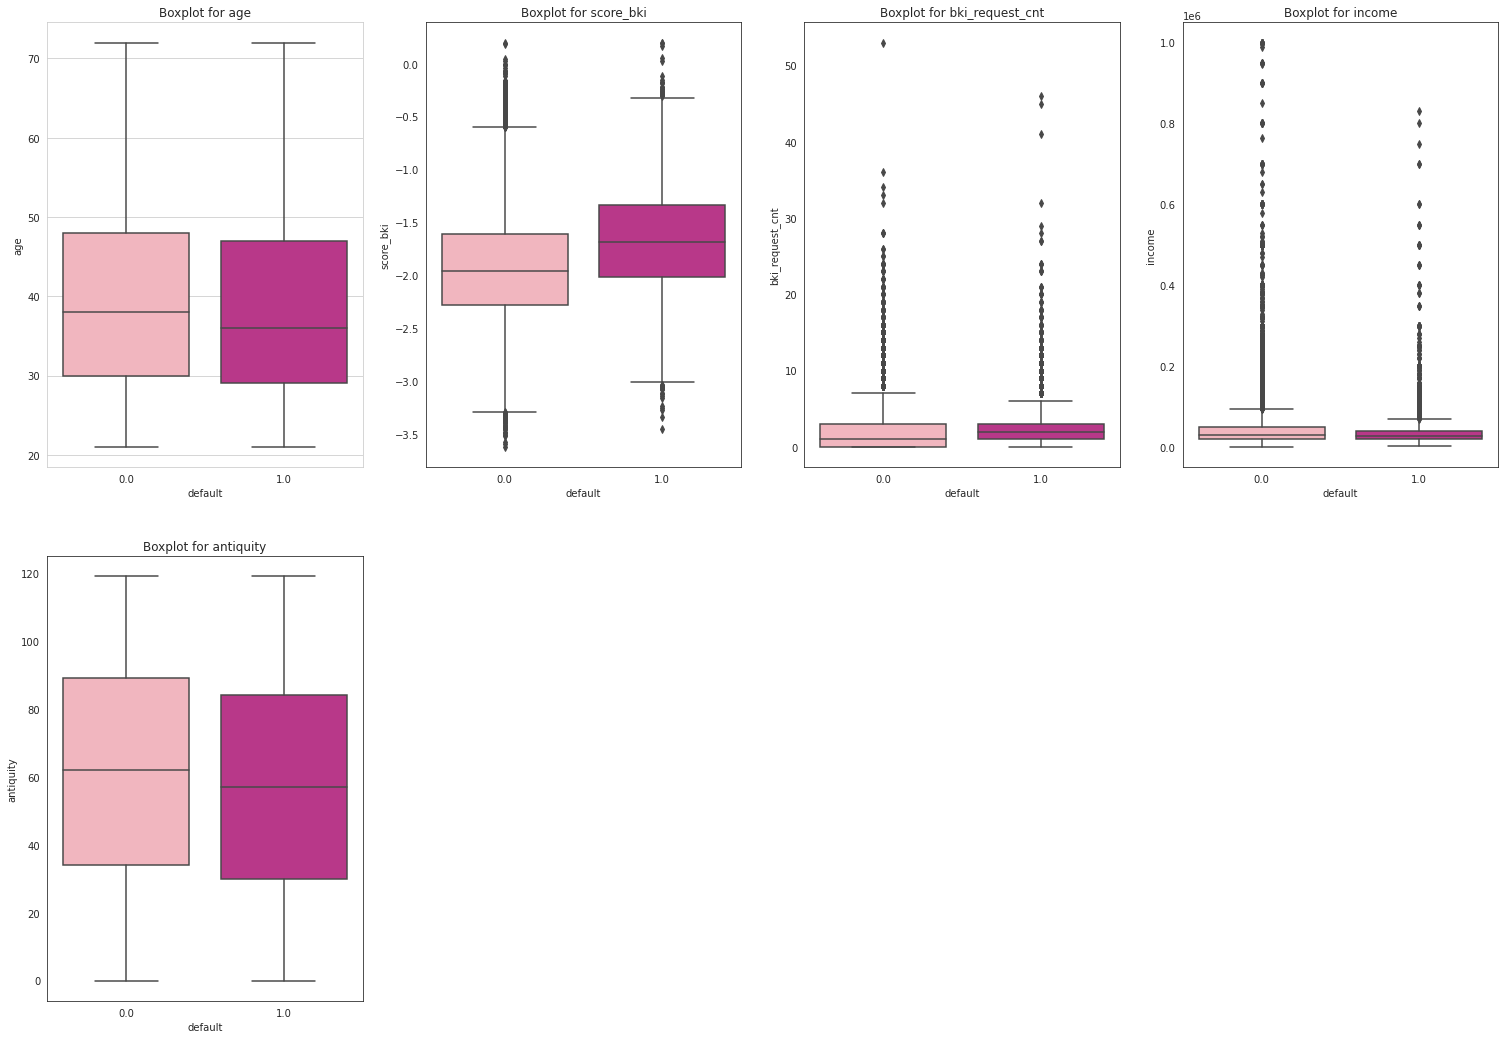

In [26]:
plt.figure(figsize=[26,18])
for i, col in enumerate(num_cols):
    plt.subplot(2, 4, i+1)
    sns.set_style("white")
    sns.boxplot(y = data[col], x = 'default', data=data,palette='RdPu').set(title='Boxplot for ' + col)

- Дефолтные клиенты в среднем немного младше, и имеют более низкий доход
- У дефолтных клиентов больше отказов и больше заявок bki в прошлом
- Как и ожидалось, у дефолтных клиентов в среднем score_bki выше
- В целом очень много выбросов в правую сторону


Теперь рассмотрим корреляцию этих числовых данных.

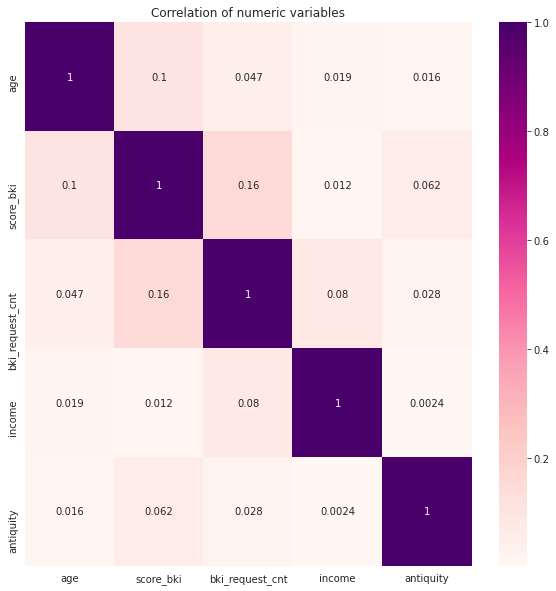

In [27]:
plt.figure(figsize=(10,10))
plt.title("Correlation of numeric variables")
sns.heatmap(data[num_cols].corr().abs(),annot=True,cmap='RdPu')
plt.show()

Как можно заметить, тут не наблюдается значительной корреляции между признаками.

## Значимость непрерывных переменных
Теперь посмотрим на значимость этих признаков с помощью f_classif.

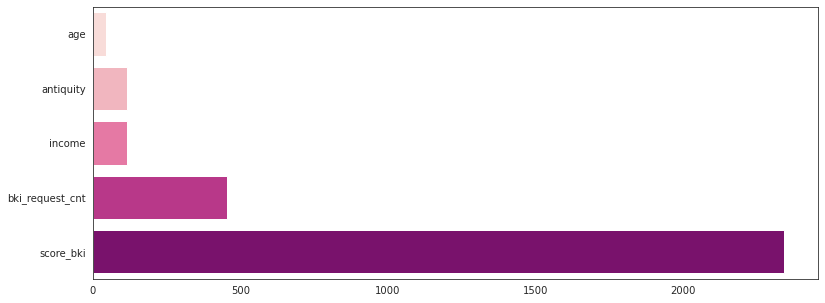

In [28]:
temp = data[data['test']==0]
imp_num = pd.Series(f_classif(temp[num_cols], temp['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
sns.set_style("white")
plt.figure(figsize=(13,5))
sns.barplot(imp_num.values,imp_num.index.values, palette='RdPu')


**score_bki** является самым значимым признаком, тогда как **age** незначительным. Стоит отметить, что **доход** находится очень низко по влиянию на дефолт, что крайне интересно.

# Рассмотрим бинарные и категориальные признаки
 

Посмотрим на распределение целевой переменной относительно cat и bin признаков.

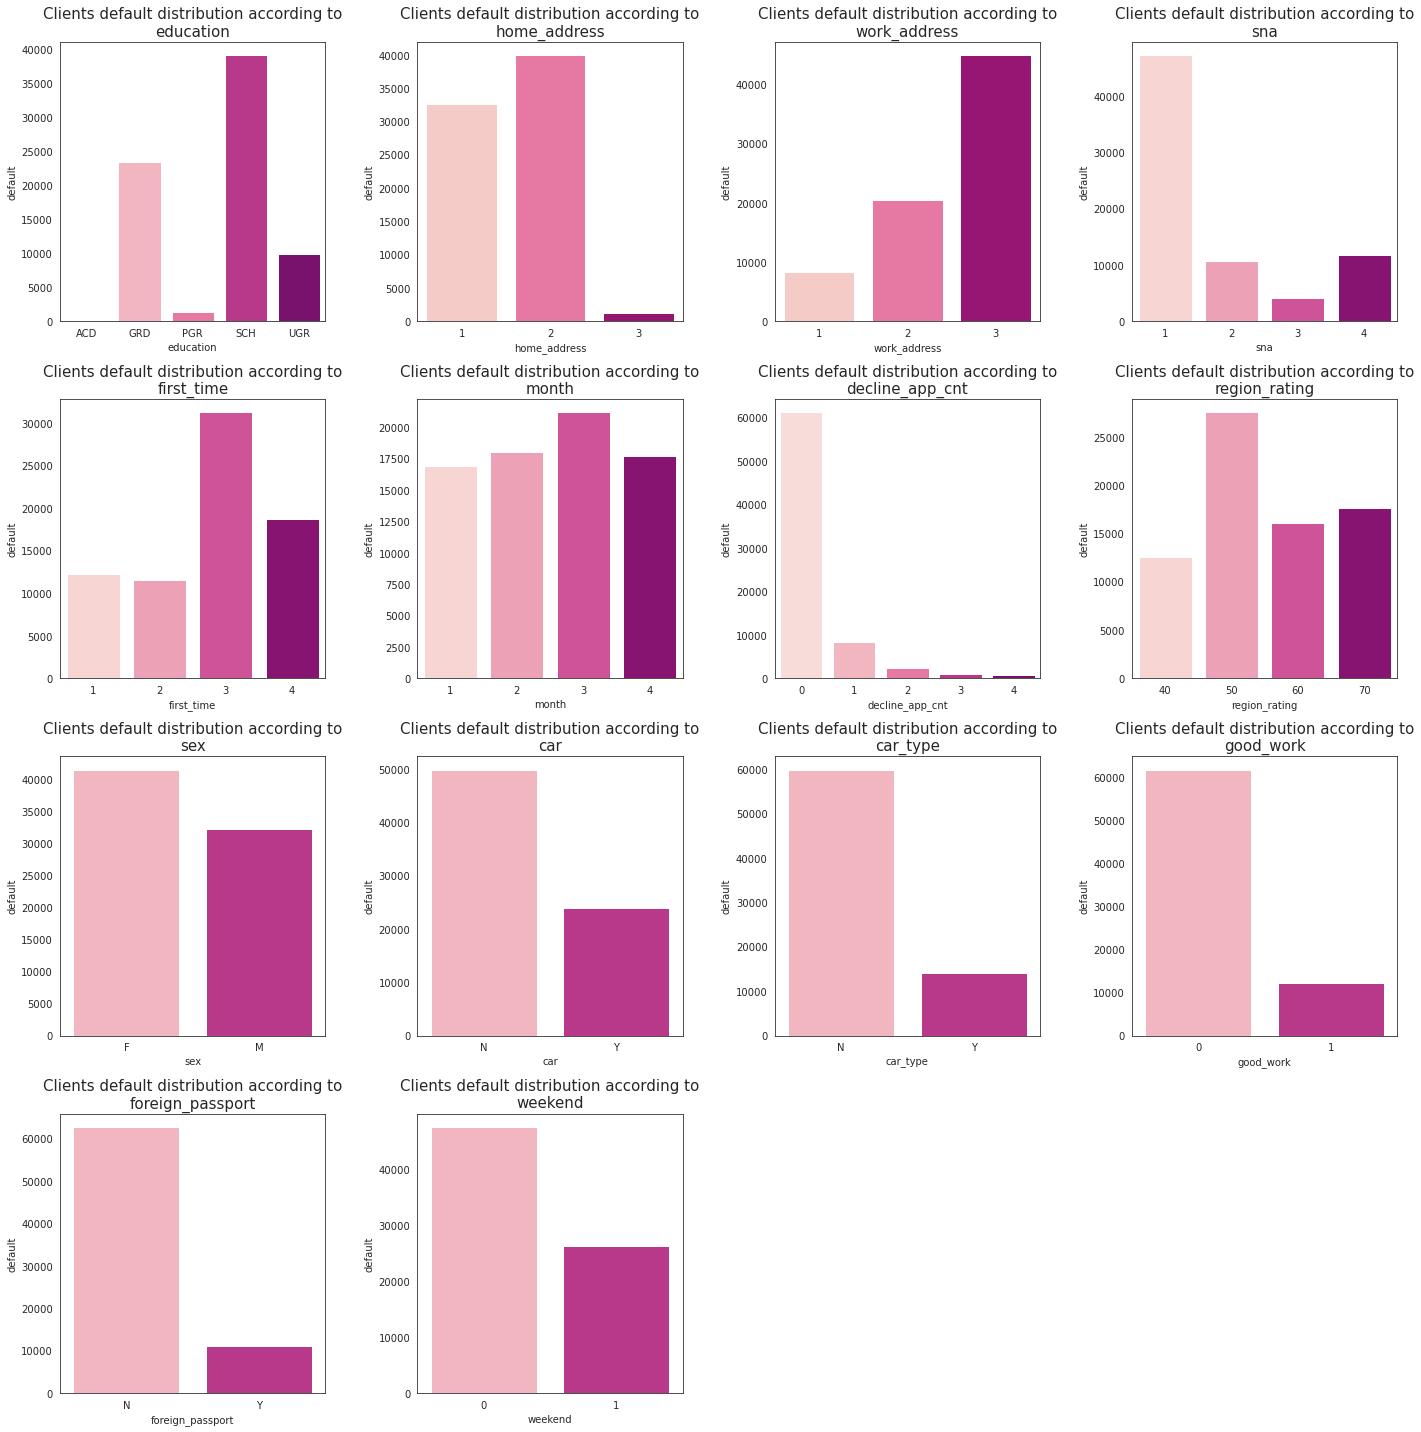

In [43]:
plt.figure(figsize=[20, 20])
i = 1

for k in (cat_cols+bin_cols):
    plt.subplot(4, 4, i)
    sns.barplot(
        y = 'default',
        x = k,
        data=data[[k, 'default']].groupby(k).count().reset_index(), palette='RdPu'
    )
    plt.title('Clients default distribution according to\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

Cамый большой процент дефолтных клиентов:

- С уровнем образования SCH и UGR
- С рабочим адресом категории 3
- С домашним адресом категории 2

Процент дефолтных несколько выше у мужчин, чем у женщин.

Большинство дефолтных клиентов не имеют машину, либо имеют, но не иномарку.

У них нет загранпаспорта и хуже работа.

А вот в целом заявок в будние дни больше, что вполне обяснимо и понятно.

In [44]:
#data.drop(columns=['month'], inplace=True)
#cat_cols.remove('month')

In [45]:
# закодируем бинарные признаки и один категориальный education
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])

data.education = label_encoder.fit_transform(data.education)

Давайте объеденим два признака car и car_type в один категориальный.

In [46]:
data['car'] = data['car']+data['car_type']
data.drop(columns=['car_type'],inplace=True)
bin_cols.remove('car_type')
bin_cols.remove('car')
cat_cols.append('car')
bin_cat = cat_cols+bin_cols

## Корреляция категориальных и бинарных признаков

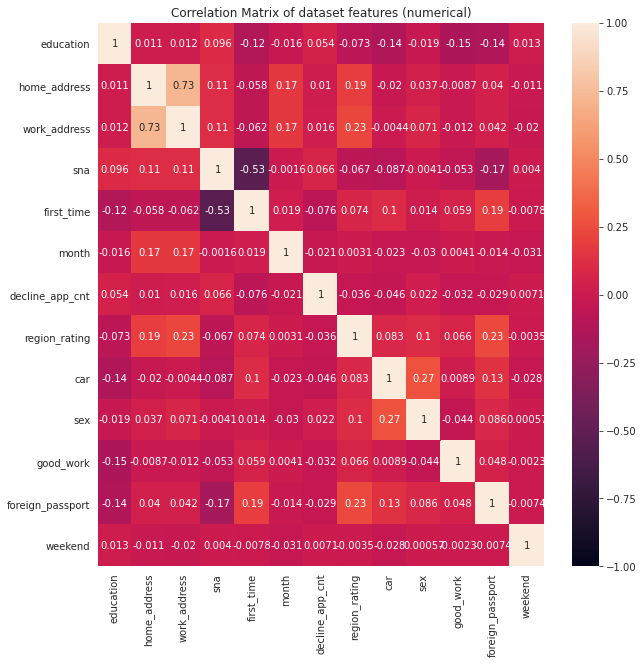

In [47]:
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix of dataset features (numerical)')
sns.heatmap(data[bin_cat].corr(), vmin=-1, vmax=1, annot = True)

Home_address и work_address имеют довольно высокую корреляцию. Так же first_time и sna имеют высокую нгативную корреляцию. Посмотрим на значимости признаков.

# Значимость категориальных и бинарных признаков

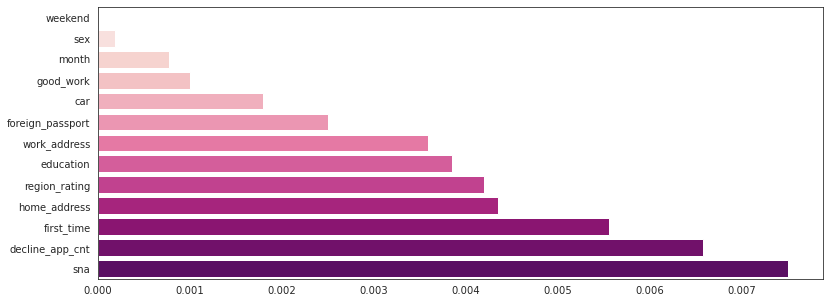

In [48]:
temp_df = data[data['test']==0]
imp_cb = pd.Series(mutual_info_classif(temp_df[bin_cat], temp_df['default'],
                                     discrete_features=True), index=bin_cat)
imp_cb.sort_values(inplace=True)
sns.set_style("white")
plt.figure(figsize=(13,5))
sns.barplot(imp_cb.values,imp_cb.index.values, palette='RdPu')
plt.show()

Можно сразу заметить признак weekend почти не влияет на нашу целевую переменную, поэтому смело убираем его.

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         110148 non-null  int64         
 3   sex               110148 non-null  int64         
 4   age               110148 non-null  int64         
 5   car               110148 non-null  int64         
 6   decline_app_cnt   110148 non-null  int64         
 7   good_work         110148 non-null  int64         
 8   score_bki         110148 non-null  float64       
 9   bki_request_cnt   110148 non-null  int64         
 10  region_rating     110148 non-null  int64         
 11  home_address      110148 non-null  int64         
 12  work_address      110148 non-null  int64         
 13  income            110148 non-null  int64         
 14  sna 

In [51]:
data.drop(columns = ['weekend'], inplace = True)
bin_cols.remove('weekend')

In [52]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)
for i in num_cols:
    data[i] = data[i].apply(lambda x: np.log(x) if x>0 else x)

# Model building
## Split the dataset

In [53]:
# Разбиваем выборку
df_train = data.query('test == 0').drop(columns = ['test','app_date','client_id'])
df_test = data.query('test == 1').drop(columns = ['test','app_date','client_id'])

In [54]:
# Делим train на valid и train
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

In [55]:
print("Train:", X.shape,
      "Test:", df_test.shape, sep='\n')

Train:
(73799, 43)
Test:
(36349, 44)


In [56]:
# function для того чтобы расчитать нужные метрики
def calc_metrics(y_test, y_pred, y_proba):    
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, y_proba)  
    metrics['confusion'] = confusion_matrix(y_test, y_pred)
    return metrics 

## Simple model

In [57]:
#pip install scikit-learn  -U
# это не помогло убрать ошибку 'str' has no attribute 'decode'
# max_iter =1000 помог

In [58]:
model_1 = LogisticRegression(penalty='none', max_iter = 1000)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_val)
y_proba = model_1.predict_proba(X_val)[:,1]

In [59]:
calc_metrics(y_val, y_pred, y_proba)

{'accuracy': 0.8747289972899729,
 'f1': 0.03848153926157046,
 'roc_auc': 0.7419858001689563,
 'confusion': array([[12874,    59],
        [ 1790,    37]])}

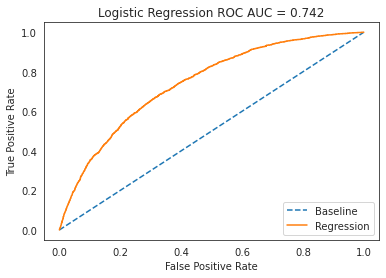

In [60]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_1.decision_function(X_val))

# plot the ROC curve
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % calc_metrics(y_val, y_pred, y_proba)['roc_auc'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


## Oversampling

In [61]:
zeroes = df_train[df_train['default']==0]
ones = df_train[df_train['default']==1]
default_new = int(len(zeroes)/len(ones))
for i in range(default_new):
    df_train = df_train.append(ones).reset_index(drop=True)

In [62]:
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)


In [63]:
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_val)
y_proba = model_1.predict_proba(X_val)[:,1]


In [64]:
calc_metrics(y_val, y_pred, y_proba)

{'accuracy': 0.6719729303649018,
 'f1': 0.6756643728852222,
 'roc_auc': 0.737059430895862,
 'confusion': array([[8590, 4395],
        [4136, 8886]])}

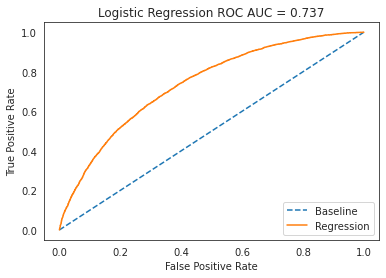

In [65]:
fpr, tpr, threshold = roc_curve(y_val, y_proba)
roc_auc = roc_auc_score(y_val, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


Результат только ухудшился.

## А теперь попробуем GradientBoostingClf

In [66]:
# Разбиваем выборку
df_train = data.query('test == 0').drop(columns = ['test','app_date','client_id'])
df_test = data.query('test == 1').drop(columns = ['test','app_date','client_id'])
# Делим train на valid и train
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

In [67]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:,1]


In [68]:
calc_metrics(y_val, y_pred, y_proba)

{'accuracy': 0.8752710027100271,
 'f1': 0.03054239073196419,
 'roc_auc': 0.7420296876779492,
 'confusion': array([[12890,    43],
        [ 1798,    29]])}

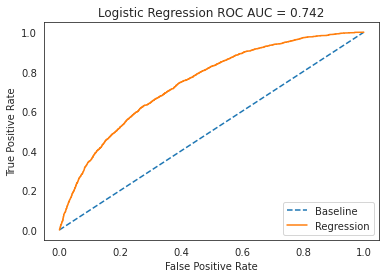

In [69]:
fpr, tpr, threshold = roc_curve(y_val, y_proba)
roc_auc = roc_auc_score(y_val, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


Тут Roc Auc лучше на незначительный поцент.

# Regularizing


In [70]:
def regul(X_train, y_train):
    C = np.logspace(0, 4, 10)
    penalty = ['l1', 'l2']
    hyperparameters = dict(C=C, penalty=penalty)
    model = LogisticRegression(random_state=42,max_iter = 1000)
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

    best_model = clf.fit(X_train, y_train)

    best_penalty = best_model.best_estimator_.get_params()['penalty']
    best_c = best_model.best_estimator_.get_params()['C']
    best_solver = best_model.best_estimator_.get_params()['solver']
    best_weight = best_model.best_estimator_.get_params()['class_weight']
    return best_penalty, best_c, best_solver, best_weight

In [71]:
regul(X_train, y_train)

('l2', 2.7825594022071245, 'lbfgs', None)

In [72]:
model = LogisticRegression(random_state=42, penalty='l2',C=1.0, solver='lbfgs',max_iter=1000,class_weight=None)
model.fit(X_train, y_train)
y_pred = model_1.predict(X_val)
y_proba = model_1.predict_proba(X_val)[:,1]

In [73]:
calc_metrics(y_val, y_pred, y_proba)

{'accuracy': 0.6661246612466125,
 'f1': 0.33976420150053593,
 'roc_auc': 0.7424445240937133,
 'confusion': array([[8564, 4369],
        [ 559, 1268]])}

А теперь результат roc_auc лучше. Но accuracy ухудшился.

# Submission

In [74]:
df_test = df_test.drop(columns = ['default'])

In [75]:
y_probs = model.predict_proba(df_test)[:,1]

In [76]:
test['default'] = y_probs
submission = test[['client_id','default']]
display(submission.sample(10))
display(submission.shape)

,client_id,default
2565,44404,0.128647
28354,57926,0.131839
21601,105331,0.038652
20992,47410,0.140951
10566,109533,0.034254
10766,48263,0.067665
22694,79544,0.089953
24956,38832,0.049963
12852,34189,0.169204
5178,49198,0.131626


(36349, 2)

In [77]:
submission.to_csv('submission.csv', index=False)